In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
from sim_utils import load_examples, Inputexample, CustomTextDataset, freeze_layers, train, test
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig

#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 16 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
data_name = 'CLINC150'
model_name = 'unsup-simcse-bert'
shot_name = 'train_5'
exp_name = f'{model_name}_lr={lr}_t={temp}_{data_name}_{shot_name}'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Path example of train, validation and test 

In [3]:
path_shot = f'../../../../Thesis/{data_name}/{shot_name}/'
valid_path = f'../../../../Thesis/{data_name}/valid/'
test_path = f'../../../../Thesis/{data_name}/test/'
print("train path : ",path_shot)
print("valid path : ",valid_path)
print("test path  : ",test_path)
print("experiment code name :",exp_name)

train path :  ../../../../Thesis/CLINC150/train_5/
valid path :  ../../../../Thesis/CLINC150/valid/
test path  :  ../../../../Thesis/CLINC150/test/
experiment code name : unsup-simcse-bert_lr=0.002_t=0.3_CLINC150_train_5


In [4]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

print("number of class :",num_class)

===== small train set ====
Train on Cross Entropy loss
len of dataset : 750
===== validation set ====
Train on Cross Entropy loss
len of dataset : 3000
===== test set ====
Train on Cross Entropy loss
len of dataset : 4500
number of class : 150


In [5]:
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased")
config = AutoConfig.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased")
config.num_labels = num_class
simcse = AutoModelForSequenceClassification.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased",config=config)
simcse = freeze_layers(simcse,freeze_layers_count=12)

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/697 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at princeton-nlp/unsup-simcse-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [6]:
optimizer= AdamW(simcse.parameters(), lr=lr)
simcse = simcse.to(device)

In [7]:
train_log, valid_log = train(exp_name,simcse,device,label_maps,optimizer,train_loader,valid_loader,train_data,valid_data,tokenizer,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.29809127998352053, 		 Training acc: 0.10799999535083771
train correct :  tensor(81, device='cuda:0')
train total : 750
 Validation Loss: 0.24140964579582214, 		 Validation acc: 0.5090000033378601
valid correct :  tensor(1527, device='cuda:0')
valid total : 3000
Validation Loss Decreased(inf--->0.241410) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.19786713822682697, 		 Training acc: 0.7573333382606506
train correct :  tensor(568, device='cuda:0')
train total : 750
 Validation Loss: 0.1756749922434489, 		 Validation acc: 0.6816666722297668
valid correct :  tensor(2045, device='cuda:0')
valid total : 3000
Validation Loss Decreased(0.241410--->0.175675) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.12851947848002115, 		 Training acc: 0.8920000195503235
train correct :  tensor(669, device='cuda:0')
train total : 750
 Validation Loss: 0.13255966862042745, 		 Validation acc: 0.7109999656677246
valid correct :  tensor(21

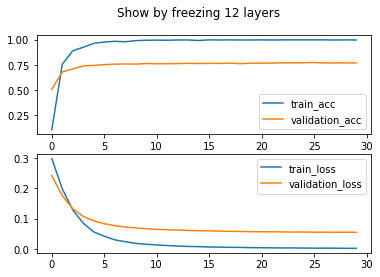

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [9]:
test_acc = test(simcse,device,label_maps,test_loader,len(test_data),tokenizer)

correct : 3416
total : 4500


In [10]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 75.91111111111111 %


In [12]:
PATH = f'../../../fewshot_models/{exp_name}.pth'
best_model = AutoModelForSequenceClassification.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased",config=config)
# Model class must be defined somewhere
best_model.load_state_dict(torch.load(PATH))
best_model = best_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at princeton-nlp/unsup-simcse-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
test_acc = test(best_model,device=device,label_maps=label_maps,test_loader=test_loader,data_size=len(test_data),tokenizer=tokenizer)

correct : 3416
total : 4500


In [14]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 75.91111111111111 %
